In [18]:
from typing import cast

import networkx as nx
import psycopg2
import torch
from dotenv import dotenv_values
from locus.models.model import LDoGIResnet
from locus.utils.cell_utils import CellState, cell_bounds, cell_center
from locus.utils.paths import MODELS_DIR, PROCESSED_DATA_DIR
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap
from networkx import DiGraph
from PIL import Image
from torchvision.transforms import v2

%matplotlib widget

In [19]:
QT = "qt_min10_max1000_df10pct.gml"
G = cast(DiGraph, nx.read_gml(PROCESSED_DATA_DIR / f"LDoGI/quadtrees/{QT}"))
active_cells = [node for node in list(G.nodes) if G.nodes[node]["state"] == CellState.ACTIVE.value]
num_classes = len(active_cells)

In [20]:
model = LDoGIResnet(num_classes, 50)

model.load_state_dict(
    torch.load(MODELS_DIR / "runs/sad-column/weights/epoch_004.pth", map_location=torch.device("cpu"))
)

<All keys matched successfully>

In [21]:
transforms = v2.Compose(
    [
        v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
        # ...
        v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
        v2.Resize(224, antialias=True),
        v2.RandomCrop(size=(224)),  # Or Resize(antialias=True)
        # ...
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # v2.ToDtype(torch.uint8, scale=True),
    ]
)

In [22]:
config = dotenv_values()

conn = psycopg2.connect(
    host=config["DB_HOST"],
    port=config["DB_PORT"],
    dbname=config["DB_NAME"],
    user=config["DB_USER"],
    password=config["DB_PASSWORD"],
)
cur = conn.cursor()

In [23]:
max_id = int(4233900 * 0.1)
from_id_train = 1
to_id_train = int(max_id * 0.7)

from_id_test = to_id_train + 1
to_id_test = from_id_test + int(max_id * 0.2)

In [24]:
# 20 random numbers between
max_id = to_id_test
min_id = from_id_test

from random import randint

id = [randint(min_id, max_id) for i in range(20)]

select_str = f"SELECT * FROM dataset WHERE id in({','.join([str(i) for i in id])})"

cur.execute(select_str)
rows = cur.fetchall()
print(rows)

# for row in rows:
#     print(row[0])

#     # save image as file
#     img = row[3]

#     with open(PROCESSED_DATA_DIR / f"LDoGI/sample_images/{row[0]}.jpg", "wb") as file:
#         file.write(img)
# print(row[0])

# img = row[1]
# img = transforms(img)
# img = img.unsqueeze(0)

# model.eval()
# with torch.no_grad():
#     output = model(img)

# print(output)


[(297160, 22.207869, 114.03238, <memory at 0x7fdccd5fb940>), (301598, 47.82082, -122.2974, <memory at 0x7fdccd5fbac0>), (308744, 45.746464, -84.89978, <memory at 0x7fdccd5fb640>), (311575, 38.742165, -90.36633, <memory at 0x7fdccd5fb580>), (312901, 47.996773, 7.851083, <memory at 0x7fdccd5fb4c0>), (314713, 39.471848, -0.323109, <memory at 0x7fdccd5fb400>), (328837, -20.318169, -40.292423, <memory at 0x7fdccd5fb340>), (329824, 41.08953, -2.776257, <memory at 0x7fdccd5fb280>), (333166, -17.931376, 25.838127, <memory at 0x7fdccd5fb100>), (336986, 34.02964, -6.835126, <memory at 0x7fdccd5faf80>), (339064, 58.95824, 6.138782, <memory at 0x7fdccd5fb040>), (341674, 48.84156, 2.274169, <memory at 0x7fdd6a061c00>), (346594, 41.29638, -3.847961, <memory at 0x7fdcc63899c0>), (354906, 38.713867, -9.13393, <memory at 0x7fdcc6389840>), (358868, 35.510845, -106.319046, <memory at 0x7fdcc6389900>), (365198, 37.89955, -4.781134, <memory at 0x7fdcc6389b40>), (366106, 51.51243, -0.118961, <memory at 0x7f

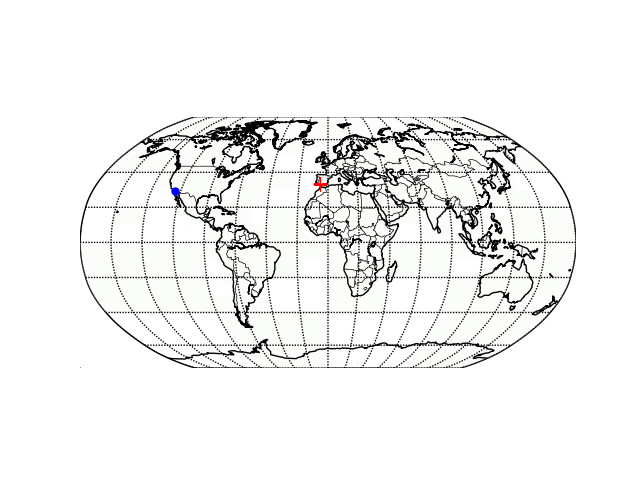

In [89]:



test_id = "budapest"

# open image from file
img = Image.open(PROCESSED_DATA_DIR / f"LDoGI/sample_images/{test_id}.jpg")
plt.imshow(img)
plt.show()

In [90]:
t_img = transforms(img)
t_img = t_img.unsqueeze(0)
t_img.shape

torch.Size([1, 3, 224, 224])

In [91]:
model.eval()
with torch.no_grad():
    output = model(t_img)

output.sum()

tensor(1.0000)

In [92]:
print(output.argmax())

tensor(717)


In [93]:
active_cells[output.argmax()]

'10223301'

In [94]:
cell_center(active_cells[output.argmax()])

(47.4609375, 18.984375)

In [95]:
b = [(active_cells[i], prob) for i, prob in enumerate(output[0])]

In [96]:
from typing import Optional
import numpy as np


def draw_screen_poly(lats, lons, m, res, color: Optional[str] = None):
    # Convert to linspace
    lats_linspace = np.linspace(lats[0], lats[1], res)
    lons_linspace = np.linspace(lons[0], lons[1], res)

    # Define the edge points' coordinates
    west_edge_lats = lats_linspace
    west_edge_lons = [lons_linspace[0]] * res
    north_edge_lats = [lats_linspace[-1]] * res
    north_edge_lons = lons_linspace
    east_edge_lats = lats_linspace[::-1]
    east_edge_lons = [lons_linspace[-1]] * res
    south_edge_lats = [lats_linspace[0]] * res
    south_edge_lons = lons_linspace[::-1]

    # Convert to map projection
    geo_rect_lats = np.concatenate(
        [
            west_edge_lats,
            north_edge_lats,
            east_edge_lats,
            south_edge_lats,
        ]
    )
    geo_rect_lons = np.concatenate(
        [
            west_edge_lons,
            north_edge_lons,
            east_edge_lons,
            south_edge_lons,
        ]
    )
    x, y = m(geo_rect_lons, geo_rect_lats)

    xy = zip(x, y)
    # get random color
    colors = ["green", "blue", "red", "yellow", "purple", "orange", "black"]
    if color is None:
        facecolor = np.random.choice(colors)
    else:
        facecolor = color

    poly = Polygon(list(xy), facecolor=facecolor, alpha=0.4)
    plt.gca().add_patch(poly)

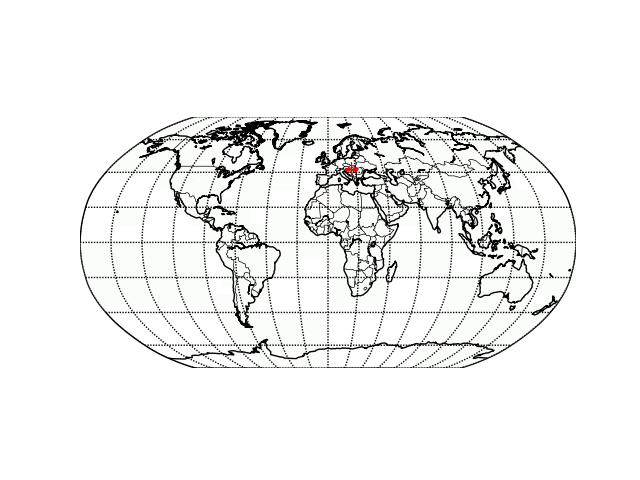

In [99]:
# lon_0 is central longitude of projection.
# resolution = 'c' means use crude resolution coastlines.


fig, ax = plt.subplots()  # a figure with a single Axes
m = Basemap(projection="robin", lon_0=0, resolution="c")


# Draw coastlines and countries
m.drawcoastlines()
m.drawcountries()
# m = Basemap(projection="robin", lon_0=0, resolution="c")
# m.fillcontinents(color="coral", lake_color="aqua")
# # draw parallels and meridians.
m.drawparallels(np.arange(-90.0, 120.0, 22.5))
m.drawmeridians(np.arange(0.0, 360.0, 22.5))
# m.drawmapboundary(fill_color="aqua")


res = 10
cmap = plt.get_cmap("Greens")
norm = plt.Normalize(0, output.max())
for cell, probability in b:
    south_lat, north_lat, west_long, east_long = cell_bounds(cell)

    color_value = cmap(norm(probability))

    draw_screen_poly((south_lat, north_lat), (west_long, east_long), m, res, color=color_value)

lat, lon = cell_center(active_cells[output.argmax()])
x, y = m(lon, lat)
m.plot(x, y, "r+", markersize=10)  # plot a blue dot there

try:
    int(test_id)
    select_str = f"SELECT latitude, longitude FROM dataset WHERE id = {test_id}"
    cur.execute(select_str)
    rows = cur.fetchall()

    x, y = m(rows[0][1], rows[0][0])

    m.plot(x, y, "b.", markersize=10)  # plot a blue dot there


except ValueError:
    pass


In [98]:
rows[0]

(32.733105, -117.14713)